In [1]:
#Image.fromarray(v.astype('uint8')) 
import numpy as np

In [40]:
#charger une image
from PIL import Image 

def preprocess_image(image_path, new_size = (256, 256)):
    image = Image.open(image_path).convert('L')
    image = image.resize(new_size)
    image = image / np.sum(image)  # Normalisation pour que la somme des pixels = 1 (ie l'image est une distribution)
    return image

In [22]:
#computes wasserstein distance
def wasserstein_distance_1d(mu0, mu1, kernel, gamma, areaWeights=None, nb_iter = 100):
    N = len(mu0)
    w = np.ones(N)
    epsilon = 1e-19

    if areaWeights is None:
        areaWeights = np.ones(N)/N #uniform
    
    for i in range(nb_iter):
        v = mu0 / (kernel(areaWeights*w) + epsilon)
        w = mu1 / (kernel(areaWeights*v) + epsilon)
    
    wass_distance = gamma * areaWeights.T @ (mu0*np.log(np.maximum(epsilon*np.ones(N),v)) + mu1*np.log(np.maximum(epsilon*np.ones(N),w)))
    
    return wass_distance, v, w


In [53]:
from scipy.ndimage import gaussian_filter
N = 10
mu = [np.random.dirichlet(np.random.rand(N)+1) for k in range(2)]
mu0, mu1 = mu[0], mu[1]
gamma = 0.1
f_heatkernel = lambda x: gaussian_filter(x, gamma/2)
wass_distance, v, w = wasserstein_distance_1d(mu1, mu1, f_heatkernel, gamma, areaWeights=None, nb_iter = 100)
print('wasserstein distance is', wass_distance)

wasserstein distance is 0.001324405785431781


In [14]:
#a supprimer?
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image

def wasserstein_distance_2d(mu0, mu1, kernel, gamma, areaWeights=None, nb_iter=100):
    N = mu0.shape[0] * mu0.shape[1]  # Nombre de pixels
    w = np.ones_like(mu0)  # Initialisation du facteur w
    if areaWeights is None:
        areaWeights = np.ones_like(mu0)/len(mu0)  # Poids de surface uniformes
    
    for i in range(nb_iter):
        v = mu0 / np.maximum(kernel(areaWeights * w), 1e-19)
        w = mu1 / np.maximum(kernel(areaWeights * v), 1e-19)
    
    # Calcul de la distance de Wasserstein avec la régularisation entropique (gamma)
    wass_distance = gamma * np.sum(areaWeights * (mu0 * np.log(np.maximum(v, 1e-19)) + mu1 * np.log(np.maximum(w, 1e-19))))
    
    return wass_distance, v, w


Distance de Wasserstein elephant/dent: 2.5866505065645457e-05
Distance de Wasserstein elephant/elephant: 8.40932352162384e-07
Distance de Wasserstein elephant/dirac: 0.00011743010264759178


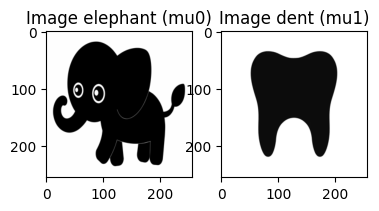

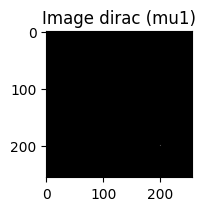

In [52]:
#chargement des images 
mu0 = preprocess_image('data/elephant.jpg') 
mu1 = preprocess_image('data/dent.jpg') 
dirac = np.zeros((256,256))
dirac[200,200] = 1

mu0_flat = mu0.ravel()
mu1_flat = mu1.ravel()
dirac_flat = dirac.ravel()

#heat kernel (=kernel gaussien en 2d)
gamma = 0.1
f_heatkernel = lambda x: gaussian_filter(x, sigma=gamma/2)  

wass_distance_elephant_dent, _, _ = wasserstein_distance_1d(mu0_flat, mu1_flat, f_heatkernel, gamma)
wass_distance_elephant_elephant, _, _ = wasserstein_distance_1d(mu0_flat, mu0_flat, f_heatkernel, gamma)
wass_distance_elephant_dirac, _, _ = wasserstein_distance_1d(mu0_flat, dirac_flat, f_heatkernel, gamma)

print(f"Distance de Wasserstein elephant/dent: {wass_distance_elephant_dent}")
print(f"Distance de Wasserstein elephant/elephant: {wass_distance_elephant_elephant}")
print(f"Distance de Wasserstein elephant/dirac: {wass_distance_elephant_dirac}")

plt.subplot(1, 3, 1)
plt.title('Image elephant (mu0)')
plt.imshow(mu0, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Image dent (mu1)')
plt.imshow(mu1, cmap='gray')
plt.show()
plt.subplot(1, 3, 3)
plt.title('Image dirac (mu1)')
plt.imshow(dirac, cmap='gray')
plt.show()